In [0]:
import numpy as np
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,  GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

Using TensorFlow backend.


In [0]:
!ls

sample_data


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
!ls

kaggle.json  sample_data


In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d hasibzunair/malaria

 99% 808M/815M [00:06<00:00, 121MB/s]
100% 815M/815M [00:06<00:00, 132MB/s]


In [0]:
!ls

kaggle.json  malaria.zip  sample_data


In [0]:
!unzip 'malaria.zip'

Archive:  malaria.zip
  inflating: y_test.npy              
  inflating: x_test.npy              
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: x_train.npy             
  inflating: x_val.npy               


In [0]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [0]:
x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [0]:
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [0]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [0]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [0]:
# model with ALL layers frozen, except for the SOFTNAX layer
def get_model_exp1_a():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.5)(X)
    predictions = Dense(2, activation='softmax')(X)
    
    # magical line of freezing layers
    for layer in base_model.layers[:-4]:
        layer.trainable=False
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
    return model

model=get_model_exp1_a()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [0]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [0]:
#!rm -f "vgg_1a.h5"

In [0]:
model=get_model_exp1_a()
path_model='vgg16_1a.h5'  

# set the learning rate (set while compiling model)
#K.set_value(model.optimizer.lr, 0.01) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=128, 
            epochs=50, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )



Instructions for updating:
Use tf.cast instead.
Train on 22046 samples, validate on 2756 samples
Epoch 1/50
22046/22046 [==============================] - 195s 9ms/step - loss: 0.2754 - acc: 0.9097 - val_loss: 0.1278 - val_acc: 0.9623
Epoch 2/50
22046/22046 [==============================] - 175s 8ms/step - loss: 0.1453 - acc: 0.9516 - val_loss: 0.1206 - val_acc: 0.9634
Epoch 3/50
22046/22046 [==============================] - 176s 8ms/step - loss: 0.1356 - acc: 0.9563 - val_loss: 0.1170 - val_acc: 0.9637
Epoch 4/50
22046/22046 [==============================] - 180s 8ms/step - loss: 0.1295 - acc: 0.9566 - val_loss: 0.1162 - val_acc: 0.9630
Epoch 5/50
22046/22046 [==============================] - 176s 8ms/step - loss: 0.1230 - acc: 0.9581 - val_loss: 0.1128 - val_acc: 0.9648
Epoch 6/50
22046/22046 [==============================] - 181s 8ms/step - loss: 0.1204 - acc: 0.9594 - val_loss: 0.1110 - val_acc: 0.9644
Epoch 7/50
22046/22046 [==============================] - 175s 8ms/step - l

In [0]:
#precision = keras_metrics.precision()
#recall = keras_metrics.recall()
#f1 = keras_metrics.f1_score()

#metrics=[precision, recall, f1, 'acc']

In [0]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()

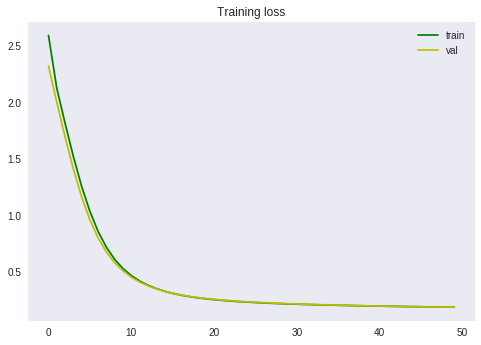

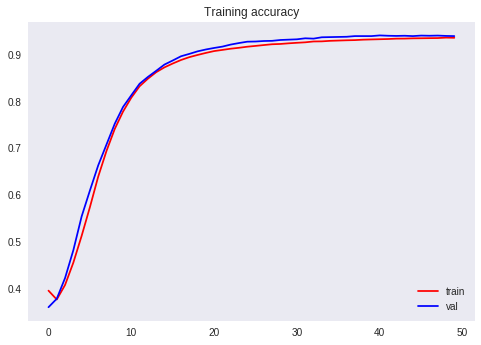

In [0]:
plot_loss_accu(h)

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12212703139784764
Test accuracy: 0.9600870827285921


| Experiments | Train | Val  | Test | Others 
|------|------|------|------|------|
|   1a   | 93.58| 93.94   | 93.57  |  Train on last layer
|   VGG   | xx | xx  | xx  | 
|   VGG   | xx| xx   | xx  | 

In [0]:
def accuracy(x_test):
  y_pred = model.predict(x_test)
  # get labels from predictions
  pred_labels = np.array([np.argmax(pred) for pred in y_pred])
  #convert ground truths to column values
  y_test = np.argmax(y_test, axis=1)
  accuracy = np.mean((y_test==pred_labels)))
  return accuracy

def evaluate_error(x_test):
    pred = model.predict(x_test, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]  
    return error
  

(2756, 2)

In [0]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])
#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [0]:
accuracy

0.9357764876632801

In [0]:
!mkdir files

In [0]:
!ls

files	     malaria.zip  vgg_1a.h5   x_train.npy  y_test.npy	y_val.npy
kaggle.json  sample_data  x_test.npy  x_val.npy    y_train.npy


In [0]:
pred_labels.shape

(2756,)

In [0]:
!os.listdir("files/")

/bin/bash: -c: line 0: syntax error near unexpected token `"files/"'
/bin/bash: -c: line 0: `os.listdir("files/")'


In [0]:
np.save("pred_labels.npy",pred_labels)
!ls

files	     malaria.zip      sample_data  x_test.npy	x_val.npy   y_train.npy
kaggle.json  pred_labels.npy  vgg16_1a.h5  x_train.npy	y_test.npy  y_val.npy


In [0]:
!cp pred_labels.npy files

In [0]:
# zip folder
!zip -r files.zip files

  adding: files/ (stored 0%)
  adding: files/pred_labels.npy (deflated 96%)


In [0]:
!ls

files	     malaria.zip      vgg16_1a.h5  x_val.npy	y_val.npy
files.zip    pred_labels.npy  x_test.npy   y_test.npy
kaggle.json  sample_data      x_train.npy  y_train.npy


In [0]:
from google.colab import files
files.download('files.zip') 